In [ ]:
import pandas as pd 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier


In [62]:
data_df = pd.read_csv("final_data/averages.csv", index_col=0)

data_df = data_df.dropna()

betting = pd.read_csv("final_data/betting.csv")

In [63]:
removed_columns = ["season", "date", "won", "target", "team", "team_opp"]
selected_columns = data_df.columns[~data_df.columns.isin(removed_columns)]

scaler = MinMaxScaler()
data_df[selected_columns] = scaler.fit_transform(data_df[selected_columns])

In [64]:
data_df_train_val = data_df[data_df.season != 2022]
target_train_val = data_df_train_val["target"]

data_df_test = data_df[data_df.season == 2022]
target_test = data_df_test["target"]

betting_test = betting[betting.season == 2022]

In [65]:
# model = LogisticRegression()
# model = SVC(probability=True)
# model = MLPClassifier()
# model = DecisionTreeClassifier()
model = RandomForestClassifier()

In [67]:
split = TimeSeriesSplit(n_splits=6)
sfs = SequentialFeatureSelector(
    model, 
    n_features_to_select=15, 
    direction="forward", 
    cv=split, 
    n_jobs=1, 
    scoring='accuracy'
)


In [68]:
sfs.fit(data_df_train_val[selected_columns], target_train_val)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
                          estimator=RandomForestClassifier(),
                          n_features_to_select=15, n_jobs=1,
                          scoring='accuracy')

In [91]:
predictors = list(selected_columns[sfs.get_support()])

In [92]:
predictors

['3p%',
 'ts%',
 'drb%',
 'usg%',
 'pts_max',
 '+/-_max',
 '3par_max',
 'stl%_max',
 'ft_opp',
 'drb_opp',
 'stl_opp',
 'usg%_opp',
 'fga_max_opp',
 '3p_max_opp',
 'won_opp']

In [84]:
parameters = {
    'n_estimators': [100, 200],         # Reduce the number of trees to two values
    'min_samples_split': [2, 5],        # Fewer options for splits
    'min_samples_leaf': [1, 2],         # Fewer options for leaf size
    'max_features': ['sqrt', 'log2'],   # Most commonly used options for features per split
}

In [99]:
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=split, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(data_df_train_val[predictors], data_df_train_val["target"])

# Get best model and parameters
model_fitted = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Display grid search results
all_results = grid_search.cv_results_
for i in range(len(all_results['params'])):
    print(f"Parameters: {all_results['params'][i]}")
    print(f"Mean Test Score: {all_results['mean_test_score'][i]:.2f}")

Best Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Test Score: 0.62
Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Test Score: 0.63
Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean Test Score: 0.63
Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean Test Score: 0.63
Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mean Test Score: 0.63
Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mean Test Score: 0.63
Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mean Test Score: 0.63
P

In [115]:
grid_search.best_score_

0.6380568356374808

In [116]:
def moneyline_to_decimal(moneyline):
    if moneyline > 0:
        return (moneyline / 100) + 1
    else:
        return (100 / abs(moneyline)) + 1

In [117]:
def calculate_return(moneyline_odds, bet_amount):
    if moneyline_odds > 0:
        return bet_amount * (moneyline_odds / 100) + bet_amount
    else:
        return bet_amount * (100 / abs(moneyline_odds)) + bet_amount

In [118]:
def backtest(data, betting, target, model, predictors):

    principal = 1000 

    principal_over_time = [principal]

    for (i,data_row),(j,betting_row), (k, target) in zip(data[predictors].iterrows(), betting.iterrows(), target.items()):

        home_decimal_odds = moneyline_to_decimal(betting_row["HomeML"])

        away_decimal_odds = moneyline_to_decimal(betting_row["AwayML"])

        prediction_row = pd.DataFrame(data_row).T
    
        home_or_away = model.predict(prediction_row)

        away_prob,home_prob = model.predict_proba(prediction_row)[0]

        if home_or_away == 1:
            bet = principal*(home_prob - away_prob/home_decimal_odds)

            odds = home_decimal_odds

            predicted_prob = home_prob
        else:
            bet = principal*(away_prob - home_prob/away_decimal_odds)

            odds = away_decimal_odds

            predicted_prob = away_prob
        
        principal -= bet

        if home_or_away == target:
            principal += calculate_return(odds, bet)
        
        principal_over_time.append(principal)
    
    return principal_over_time

In [119]:
model_fitted

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

In [120]:
principal_over_time = backtest(data_df_test, betting_test, target_test, model_fitted, predictors)

In [121]:
# Evaluate on the test set
test_predictions = model_fitted.predict(data_df_test[predictors])
test_accuracy = accuracy_score(target_test, test_predictions)

print(f"Final Test Accuracy on 2022 season: {test_accuracy:.2f}")

Final Test Accuracy on 2022 season: 0.56


In [107]:
import seaborn as sns

The principal never hits $0.


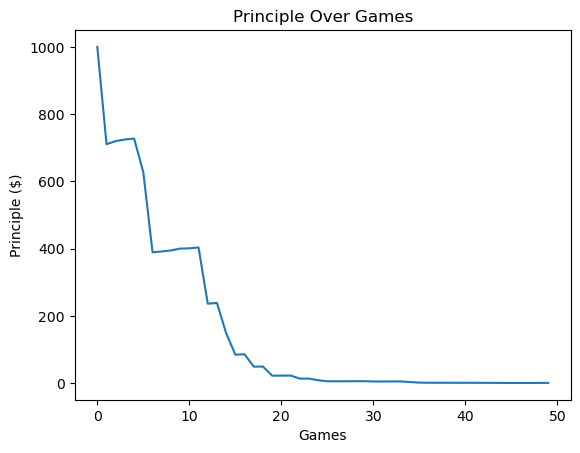

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(50), y=principal_over_time[0:50])
plt.xlabel('Games')
plt.ylabel('Principle ($)')
plt.title('Principle Over Games')

for i, value in enumerate(principal_over_time):
    if value <= 0:
        print(f"The principal hits $0 at game {i}.")
        break
else:
    print("The principal never hits $0.")